In [119]:
import pickle
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import datetime
import seaborn as sns

sys.path.append("../")
sys.path.append("../covid19_inference")

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace, format_date_axis
from covid19_soccer.plot.other import get_alpha_infections
from covid19_soccer.plot.timeseries import _uefa_range

import covid19_inference as cov19

In [4]:
""" Matplotlib config
"""
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams["figure.figsize"] = [3.4, 2.7]  # APS single column
matplotlib.rcParams["figure.dpi"] = 300  # this primarily affects the size on screen
#matplotlib.rcParams['axes.linewidth'] = 0.3
matplotlib.rcParams["axes.labelcolor"] = "black"
matplotlib.rcParams["axes.edgecolor"] = "black"
matplotlib.rcParams["xtick.color"] = "black"
matplotlib.rcParams["ytick.color"] = "black"
matplotlib.rcParams["xtick.labelsize"] = 8
matplotlib.rcParams["ytick.labelsize"] = 8
matplotlib.rcParams["axes.labelsize"] = 8
matplotlib.rcParams["axes.titlesize"]= 10
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["legend.title_fontsize"] = 8

""" Colors
Done with rcParams / see plot.rcParams
"""


""" General configs
"""
fig_path = "./figures"
# Save figure as pdf and png        
save_kwargs = {
    "transparent":True,
    "dpi":300,
    "bbox_inches":"tight"
}
jhu = cov19.data_retrieval.JHU(True)

INFO     [covid19_inference.data_retrieval._JHU] Successfully loaded data from local


In [5]:
%load_ext autoreload
%autoreload 2

## Load data/model

Load base model

In [6]:
def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)
        
tune = 1000
draws = 2000
max_treedepth = 12
country = "England"
try:
    fstr=(f"/data.nst/jdehning/covid_uefa_traces11/"+
        f"-beta=False"+
        f"-country={country}"+
        f"-offset_data=0"+
        f"-prior_delay=-1"+
        f"-width_delay_prior=0.1"+
        f"-sigma_incubation=-1.0"+
        f"-median_width_delay=1.0"+
        f"-interval_cps=10.0"+
        f"-f_fem=0.2"+
        f"-uc=True"
        f"-len=normal"+
        f"-t={1000}"+
        f"-d={1500}"+
        f"-max_treedepth={max_treedepth}.pkl")
    model, trace = load(fstr)
except:
    fstr=(f"/data.nst/jdehning/covid_uefa_traces11/"+
        f"-beta=False"+
        f"-country={country}"+
        f"-offset_data=0"+
        f"-prior_delay=-1"+
        f"-width_delay_prior=0.1"+
        f"-sigma_incubation=-1.0"+
        f"-median_width_delay=1.0"+
        f"-interval_cps=10.0"+
        f"-f_fem=0.2"+
        f"-uc=True"
        f"-len=normal"+
        f"-t={2000}"+
        f"-d={4000}"+
        f"-max_treedepth={max_treedepth}.pkl")
pm_model, trace = load(fstr)
dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country])

## Run model without soccer effect

In [7]:
import pymc3 as pm
trace_without_effect = trace.copy()
trace_without_effect.posterior["Delta_alpha_g_sparse"] = trace_without_effect.posterior["Delta_alpha_g_sparse"]*0
trace_without_effect.posterior["alpha_mean"] = trace_without_effect.posterior["alpha_mean"]*0
cases_without_effect = pm.fast_sample_posterior_predictive(
    trace_without_effect,
    model=pm_model,
    var_names=['new_E_t', 'new_cases','lambda_t'],
    keep_size=True
)


In [8]:

import theano.tensor as tt

from covid19_soccer.dataloader import Dataloader_gender, Dataloader
from covid19_soccer import delay_by_weekday
from covid19_soccer.utils import get_cps


from covid19_inference.model import (
    lambda_t_with_sigmoids,
    uncorrelated_prior_E,
    week_modulation,
    student_t_likelihood,
    delay_cases,
    Cov19Model,
    uncorrelated_prior_I,
    kernelized_spread,
    SIR,
)

def create_model_delay_only(
    dataloader=None,
    beta=True,
    use_gamma=False,
    draw_width_delay=True,
    use_weighted_alpha_prior=False,
    prior_delay=-1,
    width_delay_prior=0.1,
    sigma_incubation=-1,
    median_width_delay=1.0,
    interval_cps=10,
):
    """
    High level function to create an abstract pymc3 model using different defined
    model features. The default model is the main one described in our publication
    without any additionally modelled effect such as seasonality or temperature
    dependency.

    Parameters
    ----------
    dataloader : :class:`Dataloader`, optional
        Dataloader class for making the interaction with the data a lot
        easier. See `dataloader.py` for details. Even though the dataloader supports
        multiple countries you should only use a single one!
        Defaults to Scotland
    beta: bool
        Use beta model compartment
    use_gamma: bool
        Use gamma delay kernel

    Returns
    -------
    pymc3.Model

    """

    if dataloader is None:
        dl = Dataloader_gender(countries=["Scotland"])
    else:
        dl = dataloader

    if prior_delay == -1:
        if dl.countries[0] in ["Germany"]:
            prior_delay = 7
        elif dl.countries[0] in ["Scotland", "France", "England", "Netherlands"]:
            prior_delay = 4
        # elif dl.countries[0] in ["Portugal"]:
        # prior_delay = 5
        else:
            prior_delay = 5
            width_delay_prior = 0.15
            # raise RuntimeError("Country not known")

    # Median of the prior for the delay in case reporting, we assume 10 days
    default_interval = 10
    ratio_interval = interval_cps / default_interval
    cps_dict = dict(  # one possible change point every sunday
        relative_to_previous=True,
        pr_factor_to_previous=1.0,
        pr_sigma_transient_len=1 * ratio_interval,
        pr_median_transient_len=4 * ratio_interval,
        pr_sigma_date_transient=3.5 * ratio_interval,
    )

    # Change points every 10 days
    change_points = get_cps(
        dl.data_begin - datetime.timedelta(days=10),
        dl.data_end,
        interval=interval_cps,
        offset=5,
        **cps_dict,
    )

    if use_weighted_alpha_prior == 1:
        alpha_prior = dl.weighted_alpha_prior[0, :]
    elif use_weighted_alpha_prior == 0:
        alpha_prior = dl.alpha_prior[0, :]  # only select first country
    elif use_weighted_alpha_prior == -1:
        alpha_prior = 0.0
    else:
        raise RuntimeError(
            f"Unknown use_weighted_alpha_prior: {use_weighted_alpha_prior}"
        )

    if beta:
        beta_prior = dl.beta_prior[0, :]
        beta_weight = 1
        if (
            len(beta_prior[beta_prior > 0]) == 0
        ):  # No stadiums in home country -> don't use beta
            beta_prior = None
            stadium_size = None
    else:
        beta_prior = None
        beta_weight = None
        stadium_size = None

    # Construct model params dict
    params = {
        "new_cases_obs": dl.new_cases_obs[:, :, 0],  # only select first country
        "data_begin": dl.data_begin,
        "fcast_len": 16,
        "diff_data_sim": int((dl.data_begin - dl.sim_begin).days),
        "N_population": dl.population[:, 0],  # only select first country
    }
    with Cov19Model(**params) as this_model:
        new_cases = pm.Normal("new_E_t", 100, 1, shape=pm_model.sim_shape)
        
        # Delay the cases by a log-normal reporting delay and add them as a trace variable
        new_cases = delay_cases(
            cases=new_cases,
            name_cases="delayed_cases",
            pr_mean_of_median=prior_delay,
            pr_sigma_of_median=width_delay_prior,
            pr_median_of_width=median_width_delay / 5 * prior_delay,
            pr_sigma_of_width=0.4 / 5 * prior_delay if draw_width_delay else None,
            seperate_on_axes=False,
            num_seperated_axes=2,  # num genders
            # num_variants=dl.nGenders,
            use_gamma=use_gamma,
            diff_input_output=0,
        )

        new_cases = delay_by_weekday.delay_cases_weekday(new_cases)

        # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
        # Also adds the "new_cases" variable to the trace that has all model features.
        weekend_factor_log = pm.Normal(
            name="weekend_factor_log", mu=tt.log(0.3), sigma=0.5,
        )
        weekend_factor = tt.exp(weekend_factor_log)
        new_cases = week_modulation(
            cases=new_cases,
            name_cases="new_cases",
            pr_mean_weekend_factor=weekend_factor,
        )

        # Define the likelihood, uses the new_cases_obs set as model parameter
        student_t_likelihood(cases=new_cases, sigma_shape=1)
    return this_model
model_new = create_model_delay_only(
    dataloader=dl,
    beta=False,
    use_gamma=True,
    draw_width_delay=True,
    use_weighted_alpha_prior=0,
    prior_delay=-1,
    width_delay_prior=0.1,
    sigma_incubation=-1.0,
    median_width_delay=1.0,
    interval_cps=10.0,
)


new_E_base, new_E_alpha = get_alpha_infections(trace, pm_model, dl)
trace_primary_soccer = trace.copy()

# Summing the infectiouns without any soccer effect and the primary soccer infections
trace_primary_soccer.posterior["new_E_t"].values = cases_without_effect["new_E_t"]+new_E_alpha.reshape(cases_without_effect["new_E_t"].shape)
cases_primary_soccer = pm.fast_sample_posterior_predictive(trace_primary_soccer, model=model_new, var_names=['new_cases'], keep_size=True)

INFO     [covid19_soccer.utils] pr_sigma_lambda was set to default value 0.2
INFO     [covid19_soccer.utils] pr_median_lambda was set to default value 0.125
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_soccer.delay_by_weekday] Delaying cases by weekday
INFO     [covid19_inference.model.week_modulation] Week modulation


In [9]:
begin_uefa = datetime.datetime(2021, 6, 11)
end_uefa = datetime.datetime(2021, 7, 11)
i_begin_uefa = (begin_uefa-pm_model.sim_begin).days
i_end_uefa = (end_uefa-pm_model.sim_begin).days

num_infections_primary=np.sum(trace_primary_soccer.posterior["new_E_t"].values[:,:,i_begin_uefa:i_end_uefa,:], axis = (-1,-2))
num_infections_base=np.sum(cases_without_effect["new_E_t"][:,:,i_begin_uefa:i_end_uefa,:], axis = (-1,-2))

num_infections_primary/num_infections_base
plt.hist((num_infections_primary/num_infections_base).flatten(), bins=50)

(array([  8.,  10.,  15.,  43.,  74., 103., 155., 231., 281., 365., 490.,
        560., 600., 760., 808., 770., 765., 697., 728., 695., 620., 530.,
        455., 409., 351., 265., 229., 207., 164., 126.,  98.,  72.,  59.,
         60.,  43.,  46.,  22.,  11.,  16.,  16.,   9.,  11.,   5.,   1.,
          5.,   3.,   2.,   4.,   1.,   2.]),
 array([1.02785749, 1.03398226, 1.04010703, 1.04623179, 1.05235656,
        1.05848133, 1.0646061 , 1.07073086, 1.07685563, 1.0829804 ,
        1.08910516, 1.09522993, 1.1013547 , 1.10747947, 1.11360423,
        1.119729  , 1.12585377, 1.13197853, 1.1381033 , 1.14422807,
        1.15035284, 1.1564776 , 1.16260237, 1.16872714, 1.1748519 ,
        1.18097667, 1.18710144, 1.19322621, 1.19935097, 1.20547574,
        1.21160051, 1.21772528, 1.22385004, 1.22997481, 1.23609958,
        1.24222434, 1.24834911, 1.25447388, 1.26059865, 1.26672341,
        1.27284818, 1.27897295, 1.28509771, 1.29122248, 1.29734725,
        1.30347202, 1.30959678, 1.31572155, 1.

In [10]:
np.median(num_infections_primary/num_infections_base)

1.1316898164103504

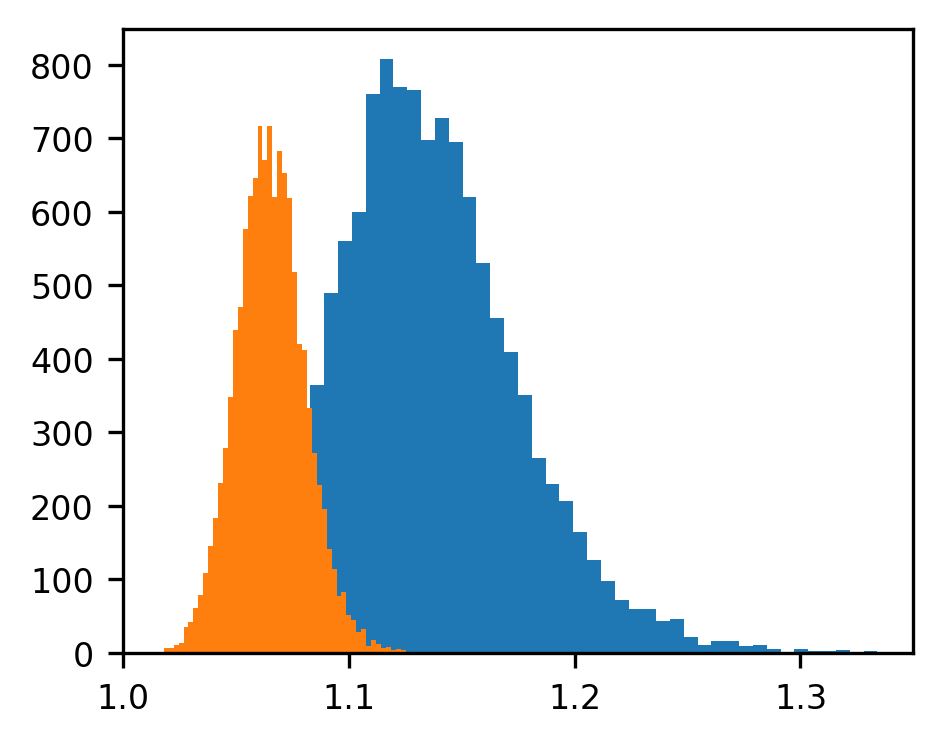

In [11]:
new_E_base, new_E_alpha = get_alpha_infections(trace, pm_model, dl)

num_infections_primary = np.sum((new_E_alpha+new_E_base)[:, i_begin_uefa:i_end_uefa], axis=(-2,-1))
num_infections_base = np.sum(new_E_base[:, i_begin_uefa:i_end_uefa], axis=(-2,-1))
soccer_effect = (num_infections_primary/num_infections_base).flatten()
plt.hist((num_infections_primary/num_infections_base).flatten(), bins=50)
plt.show()

In [12]:
new_E_base.shape

(12000, 108, 2)

In [13]:

def _delta(x, a=1, normalized=True):
    r"""
    Dirac delta peak function, normalized.

        .. math::

        \delta_a(t) = e^{-(x/a)^2}

    Parameters
    ----------
    x : tensor
        Input tensor containing the values for the delta function.
    a : number
        Shape parameter of the delta peak function.
    """
    a = tt.exp(-((x / a) ** 2))
    if normalized:
        a = a / tt.sum(a, axis=0)
    return a
def _apply_delta(eff, model, dl):
    t = np.arange(model.sim_len)
    t_g = [(game - model.sim_begin).days for game in dl.date_of_games]
    d = _delta(np.subtract.outer(t, t_g)).eval()

    return np.dot(d, eff)
S_t = get_from_trace("S_t", trace)
new_I_t = get_from_trace("new_I_t", trace)
R_t_base = get_from_trace("R_t_base", trace)
R_t_noise = get_from_trace("R_t_add_noise_fact", trace)[..., 0]
C_base = get_from_trace("C_base", trace)
C_soccer = get_from_trace("C_soccer", trace)

R_t_alpha = get_from_trace(f"alpha_R", trace)
R_t_alpha = _apply_delta(R_t_alpha.T, pm_model, dl).T
pop = pm_model.N_population
R_t_alpha

array([[ 0.00000000e+000, -4.71234872e-319, -4.90730340e-296, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000, -2.12704648e-318, -2.21505527e-295, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  3.05210041e-318,  3.17838241e-295, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
       ...,
       [ 0.00000000e+000, -1.52331308e-318, -1.58633995e-295, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  3.19724701e-319,  3.32951727e-296, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000, -1.63202729e-318, -1.69955589e-295, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000]])

In [14]:
C_base

array([[[0.56552164, 0.43447836],
        [0.43447836, 0.56552164]],

       [[0.53919908, 0.46080092],
        [0.46080092, 0.53919908]],

       [[0.51011637, 0.48988363],
        [0.48988363, 0.51011637]],

       ...,

       [[0.563168  , 0.436832  ],
        [0.436832  , 0.563168  ]],

       [[0.60262031, 0.39737969],
        [0.39737969, 0.60262031]],

       [[0.59347653, 0.40652347],
        [0.40652347, 0.59347653]]])

Extract data which we need in the following
- new_cases
- R_base

In [15]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float,axis=-1)
    ret[:,n:] = ret[:,n:] - ret[:,:-n]
    return ret[:,n - 1:] / n

# Sum over gender column and flatten chain,draw
new_cases = cases_without_effect["new_cases"].sum(-1) 
new_cases = new_cases.reshape(-1, new_cases.shape[-1])

new_cases_smooth = moving_average(new_cases,7)

R_base = cases_without_effect["lambda_t"].sum(-1) # Even though it is saved as lambda_t it is actually R
R_base = R_base.reshape(-1, R_base.shape[-1])

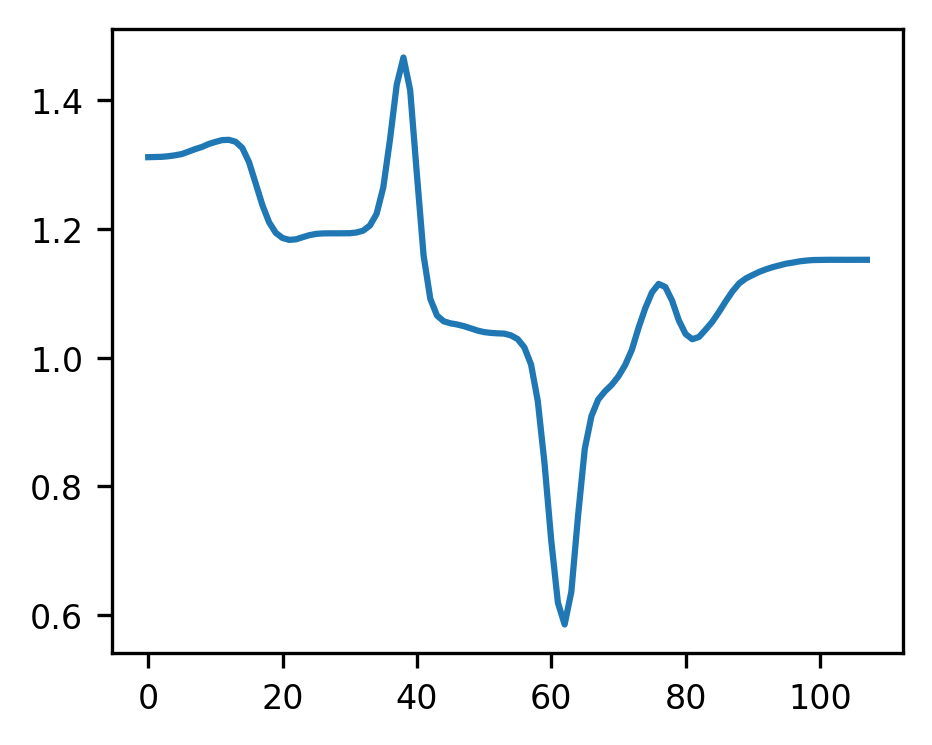

In [16]:
R_base_corrected = np.max(np.linalg.eigvals(R_base[..., None, None] * C_base[:, None]  +  np.log(R_t_noise)[..., None, None] * C_soccer[:, None]), axis=2)
plt.plot(np.median(R_base_corrected, axis=0))
plt.show()

In [17]:
np.linalg.eigvals(R_base[..., None, None] * C_base[:, None]  +  np.log(R_t_noise)[..., None, None] * C_soccer[:, None]).shape

(12000, 108, 2)

In [18]:
np.median(R_t_noise, axis=0)

array([1.02129023, 1.02131201, 1.02132608, 1.02124074, 1.02118057,
       1.02076776, 1.02056061, 1.02009878, 1.0192324 , 1.01823235,
       1.01724029, 1.01565193, 1.01398914, 1.01153917, 1.00838688,
       1.00523326, 1.00176659, 0.99835487, 0.99514235, 0.99251658,
       0.99154926, 0.99236828, 0.99485592, 0.99862058, 1.00215414,
       1.00411942, 1.00506819, 1.00530499, 1.00509139, 1.00453314,
       1.00395292, 1.00332095, 1.00241595, 1.00155311, 1.00095349,
       1.00098656, 1.00114767, 1.00189002, 1.00245899, 1.0038744 ,
       1.00586907, 1.0083005 , 1.01106907, 1.013548  , 1.01551292,
       1.01721136, 1.01709759, 1.01549007, 1.0128436 , 1.01006562,
       1.008538  , 1.00774326, 1.00821353, 1.00794129, 1.00724265,
       1.00572405, 1.00314399, 0.99956247, 0.99314889, 0.98393418,
       0.97088585, 0.95537929, 0.94121489, 0.93099677, 0.92573878,
       0.92403178, 0.92394652, 0.92487721, 0.92673489, 0.92855342,
       0.92943392, 0.92967121, 0.92944552, 0.92886264, 0.92812

In [19]:
np.median(R_t_noise, axis=0).shape

(108,)

In [20]:
np.median(C_soccer, axis=0)

array([[0.66979499, 0.33020501],
       [0.33020501, 0.10903535]])

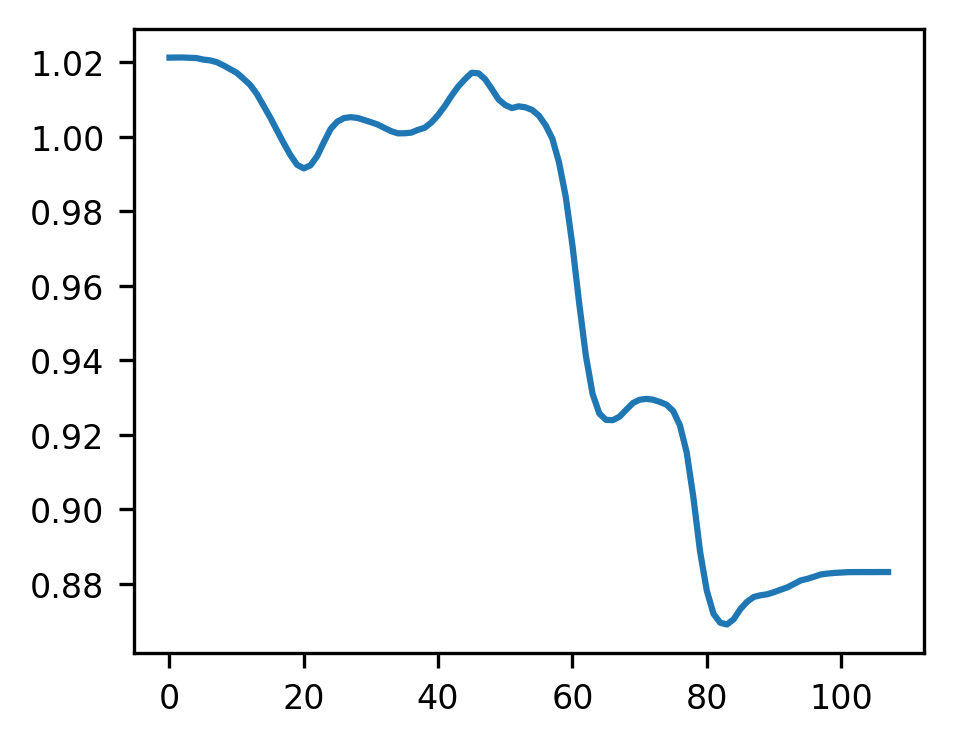

In [21]:
plt.plot(np.median(R_t_noise, axis=0))
plt.show()

In [22]:
# Sum over gender column and flatten chain,draw
new_cases_with_soccer = trace.posterior.new_cases.sum(axis=-1)
new_cases_with_soccer = new_cases_with_soccer.values.reshape(-1, new_cases_with_soccer.shape[-1])

new_cases_with_soccer_smooth = moving_average(new_cases_with_soccer,7)


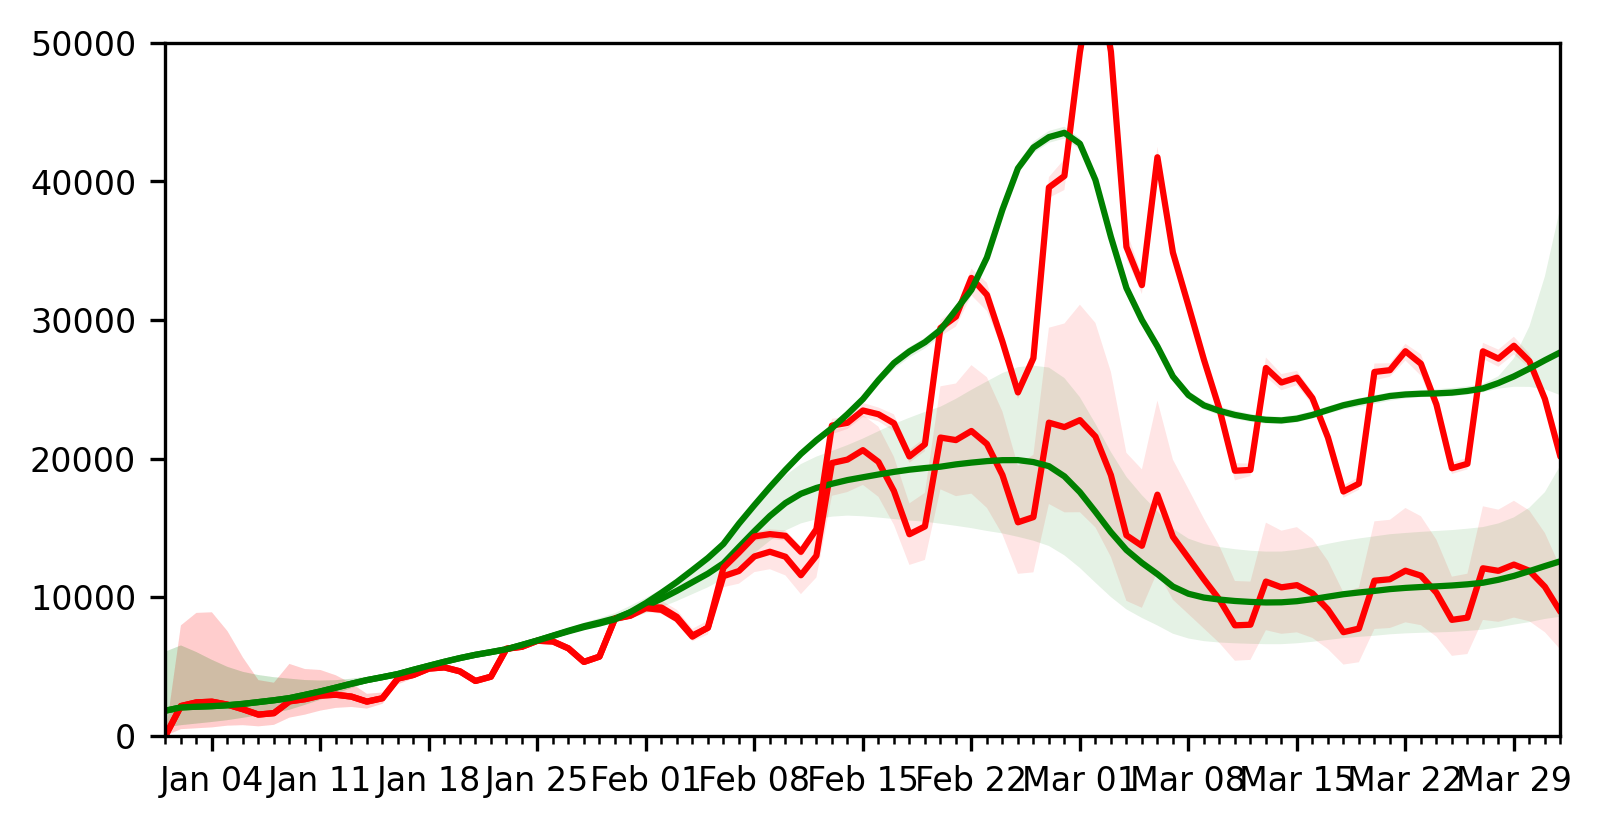

In [23]:
ax = cov19.plot._timeseries(x=np.arange(0,108),y=new_cases,what="model",color="red",)
ax = cov19.plot._timeseries(x=np.arange(0,102),y=new_cases_smooth,what="model",color="green",ax=ax)
ax = cov19.plot._timeseries(x=np.arange(0,108),y=new_cases_with_soccer,what="model",color="red",ax=ax)
ax = cov19.plot._timeseries(x=np.arange(0,102),y=new_cases_with_soccer_smooth,what="model",color="green",ax=ax)
#ax.plot(t,I,color="red")

plt.xlim(0,90)
plt.ylim(0,50000)
plt.show()

In [24]:
def model_from_trace(trace,R_add,R_base):
    """
    Paramters
    ---------
    trace: az.trace
        Full model run containing all parameters
    R_add: np.array
        Additonally R
    R_base: np.array
        Base R value shape: s,t
    """
    

In [25]:
import covid19_inference.model.utility as ut
import theano
import theano.tensor as tt


def kernelized_spread_soccer(
    R_t,
    model,
    new_E_begin, # 11
    name_new_I_t="new_I_t",
    name_new_E_t="new_E_t",
    name_S_t="S_t",
    name_new_E_begin="new_E_begin",
    name_median_incubation="median_incubation",
    pr_new_E_begin=50,
    pr_mean_median_incubation=4,
    sigma_incubation=0.4,
    return_all=False,
):

    # Total number of people in population by gender
    N = tt.as_tensor_variable(np.sum(model.N_population))  # shape: ()
    
    R_t = tt.as_tensor_variable(R_t)
    
    # Initial susceptible compartment shape: ()
    S_begin = tt.as_tensor_variable(N - np.sum(new_E_begin, axis=0))
    new_E_begin = tt.as_tensor_variable(new_E_begin)

    median_incubation = tt.as_tensor_variable(pr_mean_median_incubation)

    # Choose transition rates (E to I) according to incubation period distribution
    x = tt.as_tensor_variable(np.arange(1, 11))

    beta = tt.as_tensor_variable(ut.tt_gamma(x, median_incubation, np.exp(sigma_incubation)))


    # Define kernelized spread model:
    def next_day(
        R,
        S_t,
        nE1_m,
        nE2_m,
        nE3_m,
        nE4_m,
        nE5_m,
        nE6_m,
        nE7_m,
        nE8_m,
        nE9_m,
        nE10_m,
        _,
        beta,
        N,
    ):
        new_I_t = (
            beta[0] * nE1_m
            + beta[1] * nE2_m
            + beta[2] * nE3_m
            + beta[3] * nE4_m
            + beta[4] * nE5_m
            + beta[5] * nE6_m
            + beta[6] * nE7_m
            + beta[7] * nE8_m
            + beta[8] * nE9_m
            + beta[9] * nE10_m
        )
        # shape gender
        new_E_t = (
            S_t
            / N
            * R* new_I_t
        )

        new_E_t = tt.clip(new_E_t, 0, N)

        # Update susceptible compartment
        S_t = S_t - new_E_t
        S_t = tt.clip(S_t, -1, N)
        return S_t, new_E_t[0], new_I_t

    # theano scan returns two tuples, first one containing a time series of
    # what we give in outputs_info : S, E's, new_I
    new_I_0 = tt.cast(tt.as_tensor_variable(0.), 'float64')
    outputs, _ = theano.scan(
        fn=next_day,
        sequences=[R_t],
        outputs_info=[
            S_begin,  # shape: ()
            dict(
                initial=new_E_begin[..., 0],
                taps=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10],
            ),  # shape time,
            new_I_0,  # shape (),
        ],
        non_sequences=[beta, N],
    )

    S_t, new_E_t , new_I_t = outputs
    return new_E_t.eval()


Run different models based on R_base
- as reference:https://www.nature.com/articles/s41467-021-26013-4

In [139]:

def model_run(R_add, error, tmax=100, mu=0.11):
    """ Computes SEIR model run
    
        Parameters
        ----------
        R_add : number
            R_add value
        error : array numbers
            Additive error on R_add i.e +-
    """
    
    # Calculate lambda value from R
    lambda_mean = (np.median(R_base,axis=(0)) + R_add )** (1/4) - 1  + mu
    lambda_upper = (np.median(R_base,axis=(0)) + R_add + error[0] )** (1/4) - 1  + mu
    lambda_lower = (np.median(R_base,axis=(0)) + R_add - error[1] )** (1/4) - 1  + mu
    
    lambda_t = np.ones(tmax*2)
    t, S, I, R = SIR(lambda_mean, [67886011,np.mean(new_cases_smooth,axis=0)[0],0],t_max=tmax, mu=mu, inf_S_pool=False)
    _, _, upper, _, = SIR(lambda_upper, [67886011,np.mean(new_cases_smooth,axis=0)[0],0], mu=mu, t_max=tmax, inf_S_pool=False)
    _, _, lower, _, = SIR(lambda_lower, [67886011,np.mean(new_cases_smooth,axis=0)[0],0], mu=mu, t_max=tmax, inf_S_pool=False)
    return t, I, [lower, upper]


def model_run(R_add, error, tmax=100, mu=0.11):
    R_base_loc = np.median(R_base_corrected, axis = 0)[4:]
    R_mean = R_base_loc*(1+R_add[4:])
    R_lower = R_base_loc*(1+R_add[4:] + error[0]) 
    R_upper = R_base_loc*(1+R_add[4:] - error[1])
    mean = kernelized_spread_soccer(R_mean, pm_model, new_cases_smooth[0:11])
    upper = kernelized_spread_soccer(R_upper, pm_model, new_cases_smooth[0:11])
    lower = kernelized_spread_soccer(R_lower, pm_model, new_cases_smooth[0:11])
    return np.arange(3,3+ len(mean)), mean, [lower, upper]


R_add_mask = np.zeros(R_base_corrected.shape[1])

def transf_effect(eff_origin):
    eff_origin = np.array(eff_origin)
    eff_transformed = (1/(1-eff_origin)-1)/4.8*4
    R_add_fact = eff_transformed[0]
    R_error = [eff_transformed[0]-eff_transformed[1],eff_transformed[2]-eff_transformed[0]]
    print(R_add_fact)
    return R_add_fact, R_error


models = {}
mu = 0.11

R_add_mask[i_begin_uefa:] += 1

models["base"] = {}

eff_origin = np.percentile(soccer_effect-1, q = [50, 2.5, 97.5])-np.median(soccer_effect-1)
R_add, R_error = transf_effect(eff_origin)
t, models["base"]["I"], models["base"]["error"] = model_run(R_add*R_add_mask, R_error)
models["base"]["R_add"] = R_add
models["base"]["R_error"] = R_error

# soccer effect
eff_origin = np.percentile(soccer_effect-1, q = [50, 2.5, 97.5])
models["medium"] = {} 
R_add, R_error = transf_effect(eff_origin)
t, models["medium"]["I"], models["medium"]["error"] = model_run(R_add*R_add_mask, R_error)
models["medium"]["R_add"] = R_add
models["medium"]["R_error"] = R_error

# Mask wearing or other small restrictions
#12% [95% CI: 7–17%]
eff_origin = np.array([0.12, 0.07,0.17])
models["high"] = {}
R_add, R_error = transf_effect(eff_origin)
t, models["high"]["I"], models["high"]["error"] = model_run(R_add*R_add_mask, R_error)
models["high"]["R_add"] = R_add
models["high"]["R_error"] = R_error

# Lifting gathering ban
#26% [95% CI: 18–32%] 
eff_origin = np.array([0.26, 0.18,0.32])
models["soccer/low"] = {}
R_add, R_error = transf_effect(eff_origin)
t, models["soccer/low"]["I"], models["soccer/low"]["error"] = model_run(R_add*R_add_mask, R_error)
models["soccer/low"]["R_add"] = R_add
models["soccer/low"]["R_error"] = R_error




0.0
0.05783939198421943
0.11363636363636373
0.2927927927927928


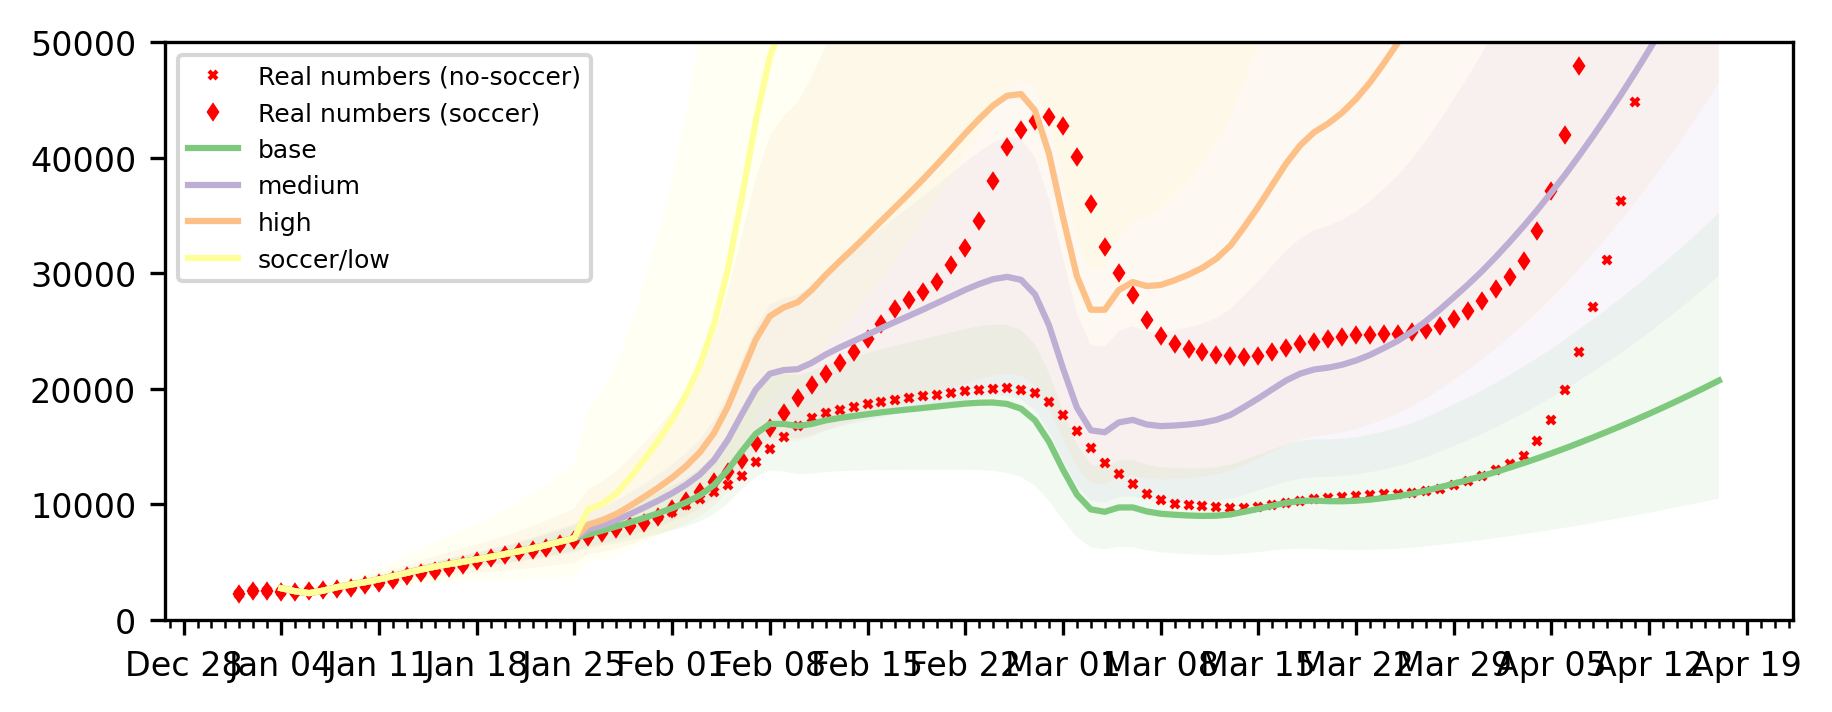

In [140]:
fig, ax= plt.subplots(1,1,figsize=(7,2.5))
cov19.plot._timeseries(x=np.arange(0,102),y=np.mean(new_cases_smooth,axis=0),what="data",color="red",ax=ax,marker="x",ms=2,label="Real numbers (no-soccer)")
cov19.plot._timeseries(x=np.arange(0,102),y=np.mean(new_cases_with_soccer_smooth,axis=0),what="data",color="red",ax=ax,marker="d",ms=2,label="Real numbers (soccer)")

cmap = plt.get_cmap("Accent")
for i,model in enumerate(models):
    ax.plot(t,models[model]["I"],label=model,color=cmap(i))
    ax.fill_between(t,models[model]["error"][0],models[model]["error"][1],color=cmap(i),alpha=0.1,edgecolor=None)

#ax = cov19.plot._timeseries(x=np.arange(0,102),y=new_cases_smooth,what="data",color="red",ax=ax)

ax.set_ylim(0,50000)
#ax.set_xlim(0,90)
plt.legend()
plt.show()

In [141]:
new_cases_with_soccer_smooth.shape

(12000, 102)

## Plotting

In [142]:
from covid19_soccer.plot.utils import lighten_color
from matplotlib.colors import to_hex
def effect_mean(ax, labels, y, y_err, colors):
    y = np.array(y)*100
    y_err = np.array(y_err)*100
    # Plot vertical lines without connection
    lines = ax.hlines(
        y=labels,
        xmin=y-y_err[:,0],
        xmax=y+y_err[:,1],
        lw=3,
        colors=colors
    )
    
    lines.set_capstyle("round")
    # Plot horizontal lines at mean
    ax.scatter(
        y=labels,
        x=y,
        marker="o",
        s=20,
        zorder=10,
        c="white",
        edgecolor=colors,
    )
    
    # Markup
    ax.set_xlabel("Change of reproduction number (%)")
    ax.set_ylim(-0.25,len(y)-0.75)
    ax.set_xlim(-5,max(y)+y_err.max())
    #ax.set_xticklabels(labels,rotation=45,ha='right')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    return ax

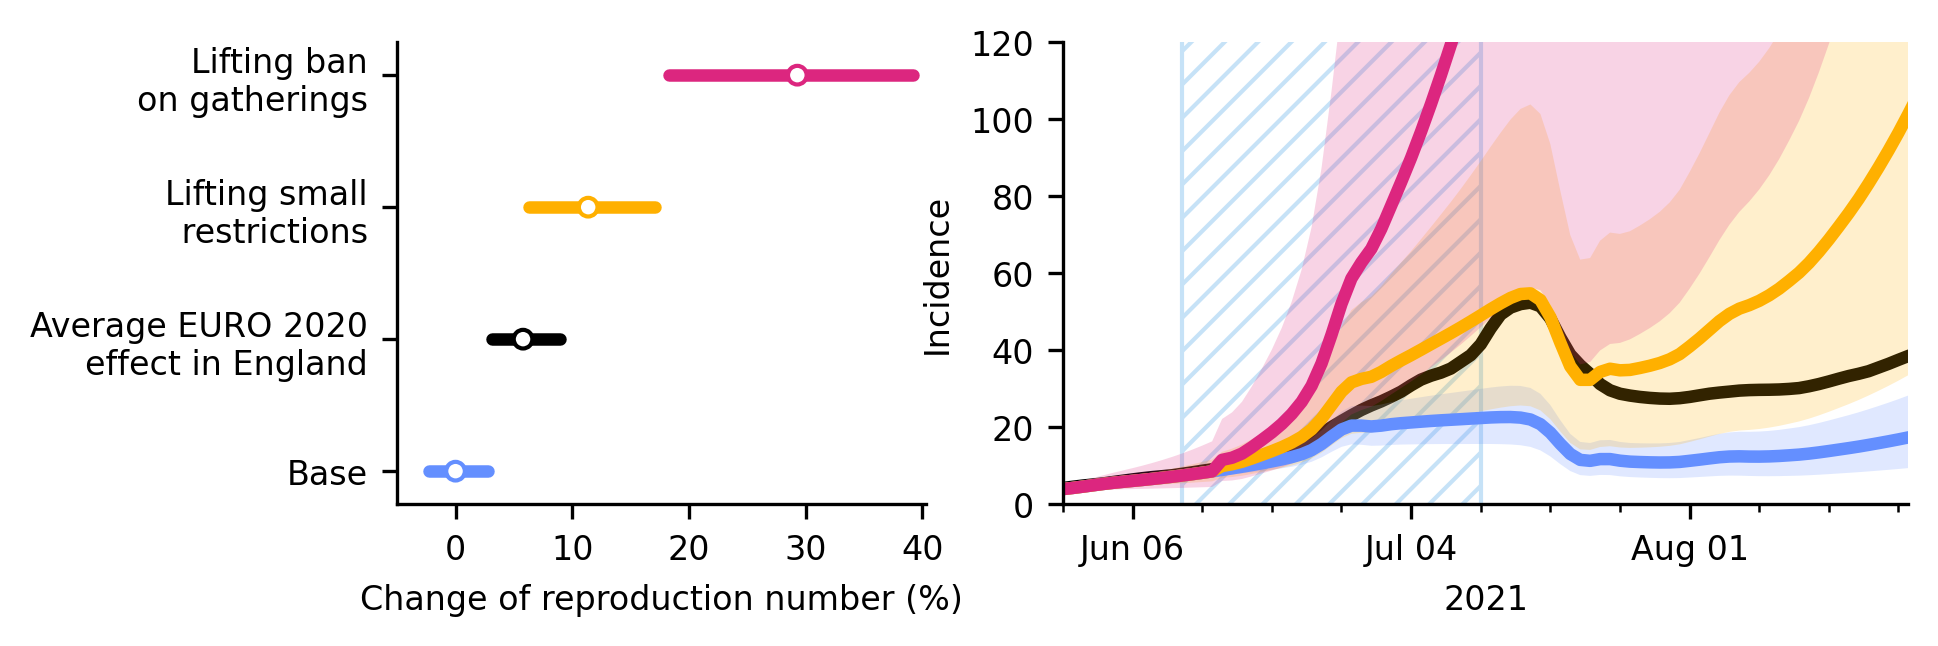

In [144]:
fig, axes = plt.subplots(1,2,figsize=(6.5,2.0),gridspec_kw={"width_ratios":[0.5,0.8,]})

# Colors
#cmap = plt.get_cmap("Accent")
#colors = #[to_hex(cmap(i),keep_alpha=True) for i in range(len(models))]
colors = ["#648fff", "black", "#ffb000", "#dc267f"]

# Plotting change in R
labels = ["Base","Average EURO 2020\neffect in England","Lifting small\n restrictions", "Lifting ban\non gatherings"]

add_R = [models[model]["R_add"] for model in models]
add_R_error = np.array([models[model]["R_error"] for model in models])
lines = effect_mean(axes[0],labels,add_R,add_R_error,colors)

# Plot real data
cov19.plot._timeseries(
    x=pd.date_range(pm_model.sim_begin,pm_model.sim_end)[3:-3],
    y=np.median(new_cases_with_soccer_smooth,axis=(0,))/83129285*100000,
    what="model",
    ax=axes[1],
    color=colors[1],
    #label="Data with soccer",
    ms=2,
    lw=3,
    zorder=-2)

# Model plots i.e. new cases
for i,model in enumerate(models):
    if i == 1: continue
    covid19_soccer.plot.timeseries._timeseries(
        ax=axes[1],
        x=pd.date_range(pm_model.sim_begin+datetime.timedelta(days=int(t[0])+5),pm_model.sim_begin+datetime.timedelta(days=int(t[-1]+5))),
        y=models[model]["I"]/83129285*100000,
        color=colors[i],
        what="model",
        date_format=False,
        lw=3
    )
    axes[1].fill_between(pd.date_range(pm_model.sim_begin+datetime.timedelta(days=int(t[0])+5),pm_model.sim_begin+datetime.timedelta(days=int(t[-1]+5))),
                         models[model]["error"][0]/83129285*100000,models[model]["error"][1]/83129285*100000,color=colors[i],alpha=0.2,edgecolor=None)
"""
covid19_soccer.plot.timeseries._timeseries(
    ax=axes[1],
    x=pd.date_range(pm_model.sim_begin,pm_model.sim_end),
    y=np.median(new_cases_with_soccer, axis=0),
    color=colors[i],
    what="model",
    date_format=False,
    lw=3
)
axes[1].fill_between(pd.date_range(pm_model.sim_begin,pm_model.sim_end),
                     *np.percentile(new_cases_with_soccer, q=(2.5,97.5), axis=0),
                     color=colors[i],alpha=0.2,edgecolor=None)
"""

    
# Markup

#axes[1].legend()
axes[1].set_xlim(datetime.datetime(2021,5,30),datetime.datetime(2021,8,23))
axes[1].set_ylim(0,120)
axes[1].set_xlabel("2021")
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].set_ylabel("Incidence")
format_date_axis(axes[1])
_uefa_range(axes[1])
fig.savefig(f"{fig_path}/what_if.pdf", **save_kwargs)
fig.savefig(f"{fig_path}/what_if.png", **save_kwargs)
plt.show()